# Stadium Billiard Assignment — Analytic Simulation

This notebook implements a clean, analytic stadium billiard simulator as required for the assignment below.

---

## **Assignment Question (from Tassignment1.pdf)**

### **Stadium Billiard**

A stadium billiard consists of a rectangle of width $2a$ and height $2b$, capped at each end by a half-ellipse of semi-axes $r_x$ (horizontal) and $r_y$ (vertical). A point particle moves freely inside the stadium, bouncing elastically off the boundary.

---

### **(a) Write down the equations for the boundary of the stadium, and describe the conditions for a collision with each part of the boundary.**

---

### **Stadium Boundary Equations**

The boundary of the stadium consists of:

1. **Rectangle (centered at origin):**

    $$ |x| \leq a, \quad |y| \leq b $$

2. **Left ellipse cap (centered at $x = -a$):**

    $$ \frac{(x + a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

3. **Right ellipse cap (centered at $x = +a$):**

    $$ \frac{(x - a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

---

### **Collision Conditions**

- **Horizontal walls:**  
  Collision occurs when $y = +b$ or $y = -b$ and $|x| \leq a$.

- **Ellipse caps:**  
  Collision occurs when the particle reaches the ellipse boundary at $x = \pm a$ and satisfies:  
  $$ \frac{(x \mp a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

- **Note:**  
  Only collisions with horizontal walls and ellipse caps are considered; there are no vertical-wall reflections at $x = \pm a$.
  

In [30]:
!pip install numpy pandas matplotlib seaborn scikit-learn jupyterlab

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [31]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import isfinite

# Stadium parameters
# Rectangle: |x| <= a, |y| <= b
# Ellipse caps: centered at x=±a, semi-axes rx, ry

a = 1.0   # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y
EPS = 1e-9 # tolerance for floating-point comparisons


In [32]:
def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    # ellipse centered at (cx,0): ((x-cx)/rx)^2 + (y/ry)^2 = 1
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    # robust quadratic solver for real roots; returns sorted positive roots list
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    # gradient of F = (x-cx)^2/rx^2 + y^2/ry^2 - 1 gives normal ~ ((x-cx)/rx^2, y/ry^2)
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    # reflect velocity vector v about (unit) normal n
    return v - 2*np.dot(v, n)*n
def kinetic_energy(vx, vy, mass=1.0):
    """Return kinetic energy for given velocity components and mass (default 1)."""
    return 0.5 * mass * (vx**2 + vy**2)


In [33]:
import pandas as pd

def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=10000, max_bounces=None, eps_nudge=1e-9):
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    X = [x]
    Y = [y]
    bounces = []
    energy_records = []
    bounce_count = 0
    q = 0
    for step in range(steps):
        remaining = dt
        while remaining > 1e-16:
            candidates = []
            if abs(vy) > 1e-16:
                for wall_y in (b, -b):
                    t = (wall_y - y)/vy
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        if abs(x_at) <= a + 1e-12:
                            ny = 1.0 if wall_y > 0 else -1.0
                            if np.dot(np.array([vx, vy]), np.array([0.0, ny])) > 1e-12:
                                candidates.append((t, 1, 'hwall', wall_y, None))
            for sx in (1.0, -1.0):
                cx = sx * a
                A, B, C = ellipse_quadratic_coeffs(x, y, vx, vy, cx)
                roots = solve_quadratic(A, B, C)
                for t in roots:
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        y_at = y + vy*t
                        if sx > 0 and x_at >= a - 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
                        if sx < 0 and x_at <= -a + 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
            if not candidates:
                x += vx * remaining
                y += vy * remaining
                remaining = 0.0
                break
            candidates.sort(key=lambda c: (c[0], c[1]))
            t_coll, _, kind, param, extra = candidates[0]
            x = x + vx * t_coll
            y = y + vy * t_coll
            if kind == 'hwall':
                ny = 1.0 if param > 0 else -1.0
                n = np.array([0.0, ny])
                v_ref = reflect(np.array([vx, vy]), n)
            else:
                cx = param
                n = ellipse_normal_at(x, y, cx)
                v_ref = reflect(np.array([vx, vy]), n)
            bounce_count += 1
            bounces.append((len(X), x, y, kind))
            v_ref = np.array(v_ref, dtype=float)
            speed = np.hypot(v_ref[0], v_ref[1])
            if speed > 0:
                v_ref = v_ref * (np.hypot(vx, vy) / speed)
            vx, vy = float(v_ref[0]), float(v_ref[1])
            vnorm = np.hypot(vx, vy)
            if vnorm > 0:
                x += (vx / vnorm) * eps_nudge
                y += (vy / vnorm) * eps_nudge
            remaining -= t_coll
            # Record energy every 10 bounces
            if bounce_count % 10 == 0:
                energy = kinetic_energy(vx, vy)
                energy_records.append({'bounce': bounce_count, 'energy': energy})
            if max_bounces is not None and bounce_count >= max_bounces:
                remaining = 0.0
                break
        if bounce_count != 0 and (bounce_count) % 10 == 0 and q == 0:
            print(f'step {step}, bounces {bounce_count}, pos=({x:.3f},{y:.3f}), vel=({vx:.3f},{vy:.3f})')
            q = 1 
        elif (bounce_count) % 10 != 0 and q == 1:
            q = 0  
        X.append(x)
        Y.append(y)
    # Record energy at last bounce if not already recorded
    if len(bounces) > 0 and (len(energy_records) == 0 or energy_records[-1]['bounce'] != bounce_count):
        energy = kinetic_energy(vx, vy)
        energy_records.append({'bounce': bounce_count, 'energy': energy})
    return np.array(X), np.array(Y), vx, vy, bounces, energy_records


In [34]:
# Implementation and meaning of variables in the simulation:

# dt: The fixed time step for each simulation loop iteration.
# dt = 0.01  # Example value, already used in simulate_trajectory

# steps: The total number of simulation steps to run.
# steps = 4000000  # Example value, already used in simulate_trajectory

# remaining: The remaining time in the current dt interval after a collision is processed.
# It is initialized to dt at the start of each step and reduced by t_coll after each collision.

# t: A candidate time to collision with a boundary (wall or ellipse), computed for each possible collision.
# For example, t = (wall_y - y) / vy for horizontal wall collision.

# t_coll: The actual time to the next collision within the current dt interval, chosen as the minimum positive t among candidates.

# Example usage in the simulation loop:
# for step in range(steps):
#     remaining = dt
#     while remaining > 1e-16:
#         # Compute all possible collision times t
#         # Select the minimum t_coll
#         # Update position by t_coll
#         # Update velocity by reflection
#         remaining -= t_coll

step 1733, bounces 10, pos=(-2.831,0.392), vel=(-0.281,-1.386)
step 3542, bounces 20, pos=(-1.716,0.932), vel=(-1.031,-0.968)
bounces recorded = 21
final velocity: 1.405273939750912 0.15876131221727144 speed: 1.414213562373095


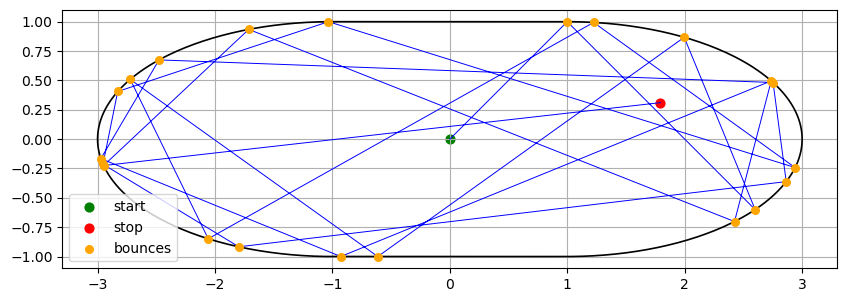

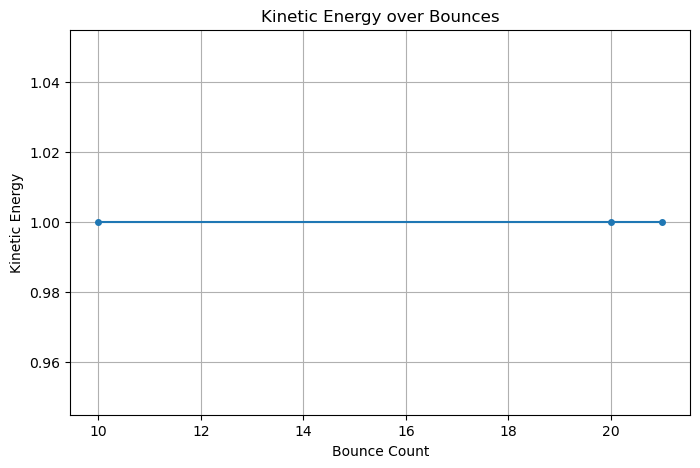

In [35]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=4000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
#plot energy over bounces
if energy_records:
    energy_table = pd.DataFrame(energy_records)
    plt.figure(figsize=(8,5))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces.png', dpi=120)
    plt.show()



step 1733, bounces 10, pos=(-2.831,0.392), vel=(-0.281,-1.386)
step 3542, bounces 20, pos=(-1.716,0.932), vel=(-1.031,-0.968)
step 5935, bounces 30, pos=(2.973,-0.132), vel=(-1.199,0.751)
step 7865, bounces 40, pos=(2.810,-0.420), vel=(-0.681,1.240)
step 9757, bounces 50, pos=(2.819,0.399), vel=(-0.602,-1.280)
step 11699, bounces 60, pos=(2.811,-0.407), vel=(-1.336,0.463)
step 13588, bounces 70, pos=(2.873,0.330), vel=(-1.364,-0.375)
step 15544, bounces 80, pos=(1.982,-0.870), vel=(-1.397,0.219)
step 17803, bounces 90, pos=(-2.983,0.102), vel=(1.316,-0.518)
step 19717, bounces 100, pos=(-2.275,0.763), vel=(-0.236,-1.394)
step 21370, bounces 110, pos=(2.419,0.690), vel=(-0.027,-1.414)
step 23019, bounces 120, pos=(-2.490,0.658), vel=(0.252,-1.392)
step 24667, bounces 130, pos=(2.546,0.627), vel=(-0.585,-1.287)
step 26328, bounces 140, pos=(-2.189,0.793), vel=(1.246,-0.668)
step 28653, bounces 150, pos=(2.141,0.818), vel=(-1.357,-0.397)
step 30780, bounces 160, pos=(-1.856,0.900), vel=(-

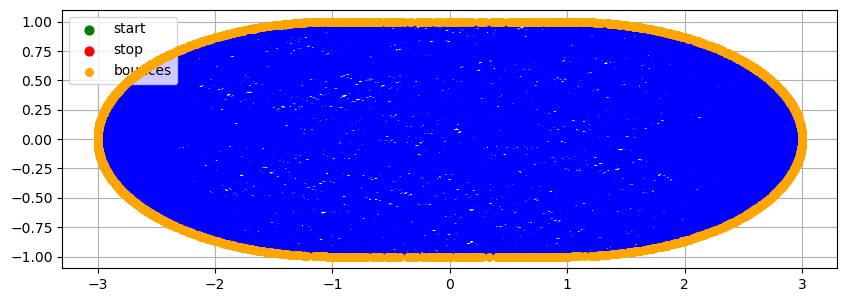

Energy conserved!
     bounce  energy
0        10     1.0
1        20     1.0
2        30     1.0
3        40     1.0
4        50     1.0
..      ...     ...
211    2120     1.0
212    2130     1.0
213    2140     1.0
214    2150     1.0
215    2154     1.0

[216 rows x 2 columns]


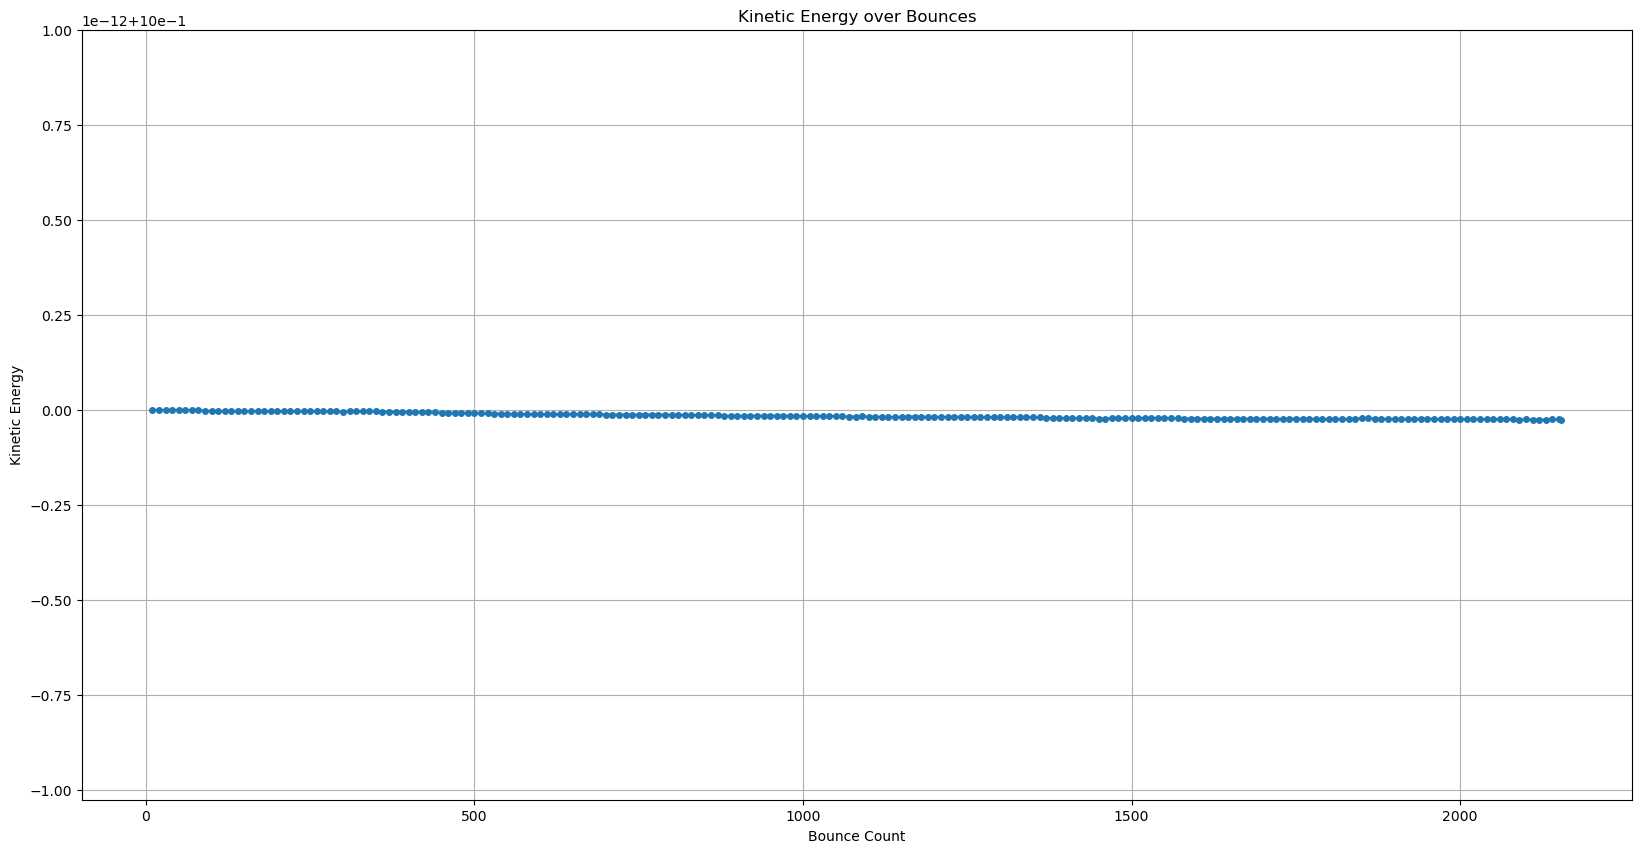

In [36]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=400000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
#plot energy over bounces
#convert to integer energy records

if energy_records:
    energy_table = pd.DataFrame(energy_records)
    if np.allclose(energy_table['energy'], 1.0, atol=1e-8):
        print("Energy conserved!")
    else:
        print("Energy not conserved!")

    plt.figure(figsize=(20,10))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    print(energy_table)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces.png', dpi=120)
    plt.show()


## Discussion: Ergodicity and Generic Initial Conditions in Stadium Billiards

In the stadium billiard, the geometry combines straight segments (rectangle) and curved caps (half-ellipses), which is known to produce chaotic dynamics. When a particle is launched with **generic initial conditions**—meaning its starting position and velocity are not specially chosen (e.g., not perfectly aligned with a symmetry axis)—the trajectory typically explores the available phase space in a complex, unpredictable manner.

### Why Generic Initial Conditions Matter

- **Non-integrable Dynamics:** The stadium billiard is not integrable; it lacks enough conserved quantities to restrict motion to regular, repeating paths.
- **Sensitive Dependence:** Small changes in initial conditions lead to vastly different trajectories due to the system's sensitivity (a hallmark of chaos).
- **Mixing:** Over time, the trajectory "mixes" through the available space, bouncing off both straight and curved boundaries.

### Ergodic-like Coverage

- **Ergodicity:** In an ergodic system, a single trajectory eventually visits every region of the allowed phase space, given enough time.
- **Stadium Billiard:** For most initial conditions, the stadium billiard exhibits ergodic-like behavior: the particle's path densely covers the interior, and time averages converge to space averages.
- **Exceptions:** Special initial conditions (e.g., perfectly vertical or horizontal velocity) may produce non-ergodic, periodic orbits, but these are rare and unstable.

### Implications

- **Statistical Properties:** Observables (like bounce locations or kinetic energy) computed along a long trajectory approximate ensemble averages.
- **Physical Realism:** In real experiments, imperfections ensure that initial conditions are generic, so ergodic-like coverage is typical.

**Conclusion:**  
Generic initial conditions in the stadium billiard lead to trajectories that densely and uniformly explore the available space, demonstrating ergodic-like behavior and supporting statistical analysis of the system.

## Sensitivity to Initial Conditions: A Diagnostic of Chaos in Stadium Billiards

One hallmark of chaotic systems is **extreme sensitivity to initial conditions**—tiny differences in starting position or velocity lead to vastly different trajectories over time. This phenomenon is often called the "butterfly effect."

### Demonstration in Stadium Billiards

To illustrate this, consider two particles launched with nearly identical initial conditions:

- **Particle A:** $(x_0, y_0, v_{x0}, v_{y0})$
- **Particle B:** $(x_0 + \delta x, y_0, v_{x0}, v_{y0})$ with $\delta x$ very small (e.g., $10^{-6}$)

Both particles start with the same velocity, but a minuscule difference in position.

#### What Happens?

- **Initially:** The trajectories are almost indistinguishable.
- **After Many Bounces:** The difference grows rapidly; the particles hit different parts of the boundary and follow unrelated paths.
- **Result:** The separation between the two trajectories increases exponentially—a signature of chaos.

### Why Does This Occur?

- **Nonlinear Reflections:** Each collision with the curved boundary (ellipse caps) amplifies small differences.
- **Phase Space Mixing:** The stadium geometry ensures that trajectories diverge quickly.

### Quantitative Measure: Lyapunov Exponent

- The **Lyapunov exponent** quantifies the rate of separation of infinitesimally close trajectories.
- A **positive Lyapunov exponent** indicates chaos.

### Visual Example

You can simulate and plot two trajectories with slightly different initial positions to observe their divergence:



### Conclusion

**Sensitivity to initial conditions** is a defining feature of chaos in the stadium billiard. Even the tiniest change in starting position or velocity leads to dramatically different outcomes, making long-term prediction impossible and confirming the system's chaotic nature.

step 1733, bounces 10, pos=(-2.831,0.392), vel=(-0.281,-1.386)
step 3542, bounces 20, pos=(-1.716,0.932), vel=(-1.031,-0.968)
step 5935, bounces 30, pos=(2.973,-0.132), vel=(-1.199,0.751)
step 7865, bounces 40, pos=(2.810,-0.420), vel=(-0.681,1.240)
step 9757, bounces 50, pos=(2.820,0.399), vel=(-0.603,-1.279)
step 11699, bounces 60, pos=(2.807,-0.418), vel=(-1.329,0.484)
step 12685, bounces 70, pos=(2.505,0.657), vel=(-1.333,0.472)
step 13572, bounces 80, pos=(2.965,-0.180), vel=(-0.241,1.393)
step 15024, bounces 90, pos=(-2.715,-0.511), vel=(1.412,-0.086)
step 16967, bounces 100, pos=(-1.397,-0.980), vel=(1.297,0.563)
step 19535, bounces 110, pos=(-2.823,0.409), vel=(0.249,-1.392)
step 21486, bounces 120, pos=(-2.989,0.032), vel=(1.322,0.501)
step 23360, bounces 130, pos=(-1.429,-0.967), vel=(-0.831,1.144)
step 25065, bounces 140, pos=(2.847,-0.374), vel=(-1.218,0.719)
step 26920, bounces 150, pos=(1.287,-0.986), vel=(1.151,0.822)
step 28939, bounces 160, pos=(2.944,-0.218), vel=(-1.

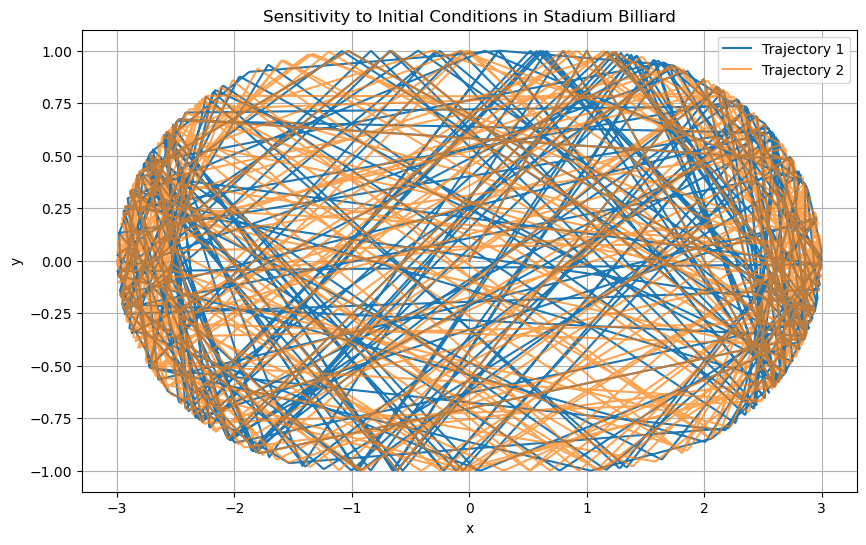

In [37]:
X1, Y1, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=40000)
X2, Y2, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0 + 1e-6, 0.0, 1, 1, dt=0.01, steps=40000)

plt.figure(figsize=(10,6))
plt.plot(X1, Y1, label='Trajectory 1')
plt.plot(X2, Y2, label='Trajectory 2', alpha=0.7)
plt.legend()
plt.title('Sensitivity to Initial Conditions in Stadium Billiard')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


## Part B: Time-Dependent Schrödinger Equation for Gaussian Wave Packet in Stadium

This section solves the time-dependent Schrödinger equation for a Gaussian wave packet inside the same stadium billiard as in Part A. We use the split-operator method for numerical evolution.

The stadium has infinite potential walls, so the wave function is zero on the boundary. The initial wave packet is Gaussian with momentum.


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from scipy.ndimage import distance_transform_edt

# Reuse stadium parameters from Part A
a = 1.0   # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y

# Quantum parameters
hbar = 1.0  # set to 1
m = 1.0     # mass
Nx, Ny = 256, 256  # grid size
dx = dy = 0.05     # grid spacing
dt = 0.001         # time step
T_steps = 3000     # number of time steps
sigma = 0.2        # Gaussian width
x0, y0 = random.random(), random.random()  # initial position
px, py = 2.0, 0  # initial momentum

# Define grid
x = np.linspace(-a - rx, a + rx, Nx) * 1.5  # extend grid
y = np.linspace(-b - ry, b + ry, Ny) * 1.5
X, Y = np.meshgrid(x, y)


In [39]:
def stadium_mask(X, Y, a, b, rx, ry):
    # Rectangle part
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    # Left ellipse
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    # Right ellipse
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

mask = stadium_mask(X, Y, a, b, rx, ry)


In [40]:
mask = stadium_mask(X, Y, a, b, rx, ry)

# Momentum grid
kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)
ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)
KX, KY = np.meshgrid(kx, ky)
k2 = (KX**2 + KY**2) * hbar**2 / (2 * m)

In [41]:
V = 1e6 * (1 - mask)  # Large potential outside to approximate infinite walls

In [42]:
# Initial Gaussian wave packet
psi = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2) + 1j * (px * X + py * Y) / hbar)
psi *= mask  # enforce boundary

# Normalize
norm = np.sum(np.abs(psi)**2) * dx * dy
psi /= np.sqrt(norm)


In [43]:
def evolve_psi(psi, k2, dt, V):
    # Split-operator: kinetic in momentum space, potential in position space
    # Potential is 0 inside, inf in walls, 0 outside
    
    # Half potential step
    V_finite = np.where(np.isinf(V), 0, V)
    exp_factor = np.exp(-1j * V_finite * dt / (2 * hbar))
    psi = psi * exp_factor
    psi = np.where(np.isinf(V), 0, psi)
    
    # Kinetic step
    psi_k = fft2(psi)
    psi_k *= np.exp(-1j * k2 * dt / hbar)
    psi = ifft2(psi_k)
    
    # Half potential step
    exp_factor = np.exp(-1j * V_finite * dt / (2 * hbar))
    psi = psi * exp_factor
    psi = np.where(np.isinf(V), 0, psi)
    
    # Compute norm (should be preserved)
    current_norm = np.sum(np.abs(psi)**2) * dx * dy
    
    return psi, current_norm

In [44]:
from tqdm import tqdm

# Time evolution
T_steps = 3000
psi_t = [psi.copy()]
norms = []
for t in tqdm(range(T_steps), desc="Time Evolution"):
    psi, current_norm = evolve_psi(psi, k2, dt, V)
    norms.append(current_norm)
    if t % 50 == 0:
        psi_t.append(psi.copy())
print(f"Evolution completed for {T_steps} steps.")
print(f"Norms range: {min(norms):.6f} to {max(norms):.6f}")


Time Evolution: 100%|██████████| 3000/3000 [00:11<00:00, 251.02it/s]

Evolution completed for 3000 steps.
Norms range: 1.000000 to 1.000000


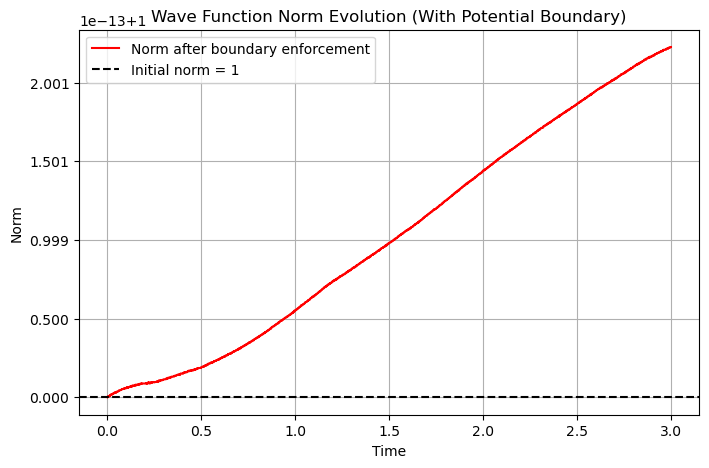

Average norm: 1.000000
Standard deviation: 0.000000
Final norm: 1.000000


In [45]:
# Plot norm evolution over time
plt.figure(figsize=(8, 5))
times = np.arange(T_steps) * dt
plt.plot(times, norms, 'r-', label='Norm after boundary enforcement')
plt.axhline(y=1.0, color='k', linestyle='--', label='Initial norm = 1')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Wave Function Norm Evolution (With Potential Boundary)')
plt.legend()
plt.grid(True)
plt.savefig('norm_evolution.png', dpi=120)
plt.show()

print(f"Average norm: {np.mean(norms):.6f}")
print(f"Standard deviation: {np.std(norms):.6f}")
print(f"Final norm: {norms[-1]:.6f}")

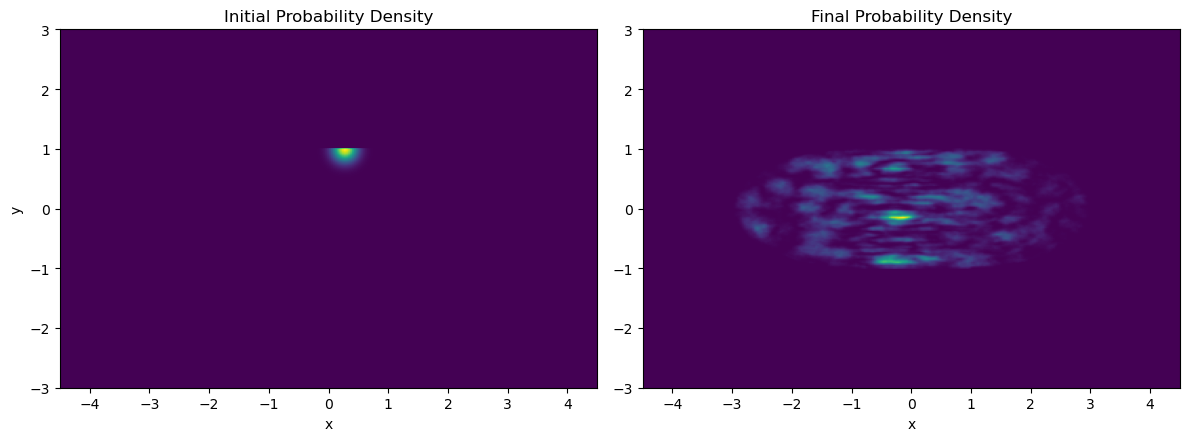

In [46]:
# Plot initial and final probability density
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Initial
prob_initial = np.abs(psi_t[0])**2
axes[0].imshow(prob_initial, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
axes[0].set_title('Initial Probability Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Final
prob_final = np.abs(psi_t[-1])**2
axes[1].imshow(prob_final, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
axes[1].set_title('Final Probability Density')
axes[1].set_xlabel('x')

plt.tight_layout()
plt.savefig('stadium_quantum_wavepacket.png', dpi=120)
plt.show()


Wall Widths:  17%|█▋        | 1/6 [00:10<00:51, 10.24s/it]

Wall width: 0.000, Mean |diff| inside: 0.037866


Wall Widths:  33%|███▎      | 2/6 [00:20<00:40, 10.17s/it]

Wall width: 0.020, Mean |diff| inside: 0.037866


Wall Widths:  50%|█████     | 3/6 [00:30<00:30, 10.14s/it]

Wall width: 0.040, Mean |diff| inside: 0.037866


Wall Widths:  67%|██████▋   | 4/6 [00:40<00:20, 10.12s/it]

Wall width: 0.060, Mean |diff| inside: 0.050348


Wall Widths:  83%|████████▎ | 5/6 [00:50<00:10, 10.14s/it]

Wall width: 0.080, Mean |diff| inside: 0.049795


Wall Widths: 100%|██████████| 6/6 [01:00<00:00, 10.15s/it]


Wall width: 0.100, Mean |diff| inside: 0.048801


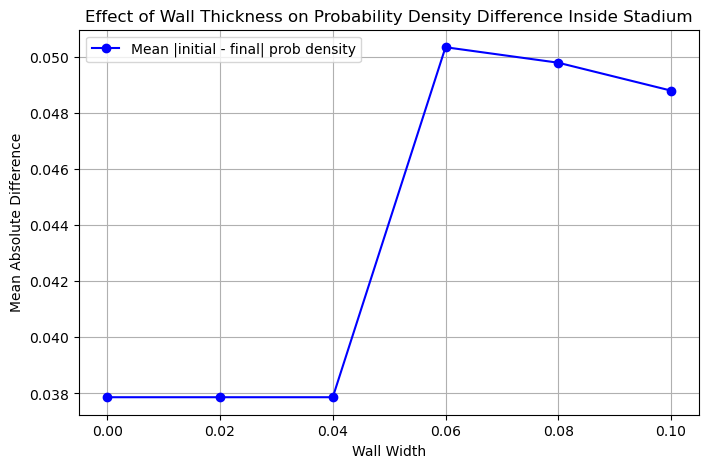

In [48]:
from tqdm import tqdm

# Study effect of wall thickness on probability density difference
wall_widths = np.linspace(0, 0.1, 6)  # vary from 0 to 0.1
differences = []

for wall_width in tqdm(wall_widths, desc="Wall Widths"):
    # Compute distance from stadium boundary
    dist = distance_transform_edt(1 - mask)
    # Wall region: outside stadium, within wall_width of boundary
    wall_mask = (dist <= wall_width / dx) & (~mask)  # dist in grid units
    V = np.where(wall_mask, np.inf, 0)
    
    # Initial psi
    psi = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2) + 1j * (px * X + py * Y) / hbar)
    psi *= mask  # enforce initial boundary
    norm = np.sum(np.abs(psi)**2) * dx * dy
    psi /= np.sqrt(norm)
    
    prob_initial = np.abs(psi)**2
    
    # Evolve
    for t in tqdm(range(T_steps), desc=f"Evolving wall {wall_width:.3f}", leave=False):
        psi, _ = evolve_psi(psi, k2, dt, V)
    
    prob_final = np.abs(psi)**2
    
    # Difference inside stadium (mask)
    diff = prob_initial - prob_final
    diff_inside = diff[mask]
    mean_abs_diff = np.mean(np.abs(diff_inside))
    differences.append(mean_abs_diff)
    
    print(f"Wall width: {wall_width:.3f}, Mean |diff| inside: {mean_abs_diff:.6f}")

# Plot difference vs wall width
plt.figure(figsize=(8, 5))
plt.plot(wall_widths, differences, 'bo-', label='Mean |initial - final| prob density')
plt.xlabel('Wall Width')
plt.ylabel('Mean Absolute Difference')
plt.title('Effect of Wall Thickness on Probability Density Difference Inside Stadium')
plt.legend()
plt.grid(True)
plt.savefig('wall_thickness_effect.png', dpi=120)
plt.show()

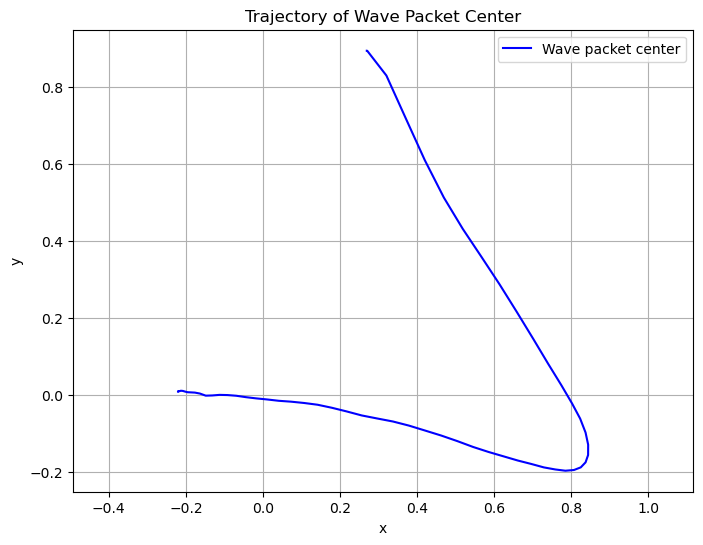

In [ ]:
# Compute some observables
center_x = []
center_y = []
for psi_snap in psi_t:
    prob = np.abs(psi_snap)**2
    cx = np.sum(X * prob) * dx * dy
    cy = np.sum(Y * prob) * dx * dy
    center_x.append(cx)
    center_y.append(cy)

plt.figure(figsize=(8,6))
plt.plot(center_x, center_y, 'b-', label='Wave packet center')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of Wave Packet Center')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.savefig('wavepacket_trajectory.png', dpi=120)
plt.show()


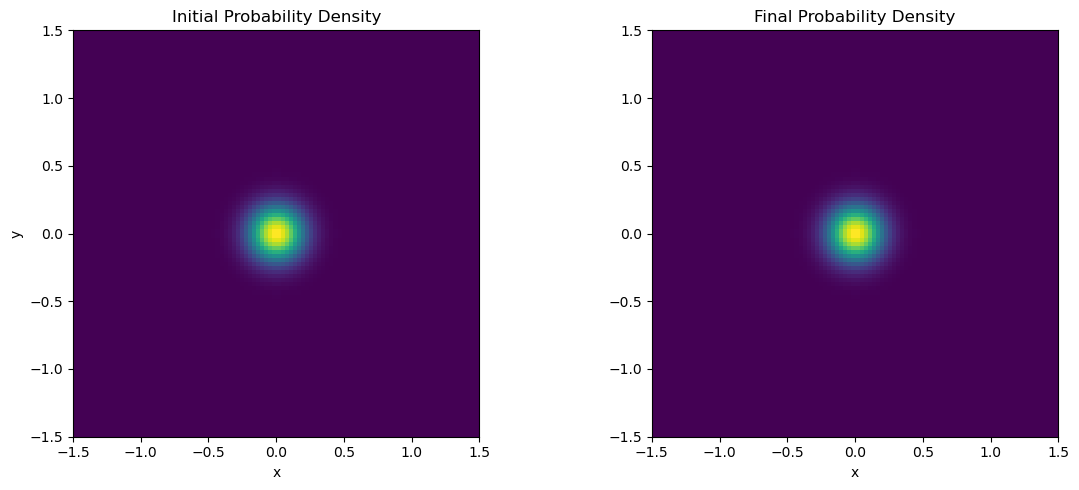

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye

# Parameters
Nx, Ny = 100, 100
Lx, Ly = 3.0, 3.0
x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

# Stadium mask
def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

a, b, rx, ry = 1.0, 1.0, 2.0, 1.0
mask = stadium_mask(X, Y, a, b, rx, ry)
mask_flat = mask.flatten()

# Build Hamiltonian (finite difference Laplacian)
main_x = -2.0 * np.ones(Nx)
off_x = np.ones(Nx-1)
Dx = diags([main_x, off_x, off_x], [0, -1, 1]) / dx**2
Ix = eye(Nx)
main_y = -2.0 * np.ones(Ny)
off_y = np.ones(Ny-1)
Dy = diags([main_y, off_y, off_y], [0, -1, 1]) / dy**2
Iy = eye(Ny)
Laplacian = kron(Iy, Dx) + kron(Dy, Ix)
H = -0.5 * Laplacian

# Apply mask: set large energy outside stadium
H = H.tolil()
for i in range(Nx*Ny):
    if not mask_flat[i]:
        H[i, :] = 0
        H[i, i] = 1e10
H = H.tocsr()

# Chebyshev time evolution function
def chebyshev_evolve(psi0, H, dt, steps, mask_flat, order=30):
    # Scale Hamiltonian to [-1,1]
    Emax = 2 * np.abs(H).max()
    Hs = (2 * H / Emax) - eye(H.shape[0])
    a = Emax / 2
    b = Emax / 2

    psi = psi0.copy()
    psi_t = [psi.copy()]
    for _ in range(steps):
        # Chebyshev expansion
        T0 = psi.copy()
        T1 = -1j * dt * Hs.dot(psi)
        psi_new = T0 + T1
        for n in range(2, order):
            T2 = -2j * dt * Hs.dot(T1) + T0
            psi_new += T2
            T0, T1 = T1, T2
        # Enforce boundary
        psi_new[~mask_flat] = 0
        psi = psi_new / np.linalg.norm(psi_new)
        psi_t.append(psi.copy())
    return psi_t

# Initial wave packet
x0, y0 = 0.0, 0.0
sigma = 0.2
psi0 = np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2))
psi0 *= mask
psi0 = psi0.flatten()
psi0 /= np.linalg.norm(psi0)

# Time evolution
dt = 0.01
T_steps = 100
psi_t = chebyshev_evolve(psi0, H, dt, T_steps, mask_flat, order=30)

# Plot initial and final probability density
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(psi_t[0].reshape(Ny, Nx))**2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.title('Initial Probability Density')
plt.xlabel('x'); plt.ylabel('y')
plt.subplot(1,2,2)
plt.imshow(np.abs(psi_t[-1].reshape(Ny, Nx))**2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.title('Final Probability Density')
plt.xlabel('x')
plt.tight_layout()
plt.show()